In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import researchpy as rp
import scipy.stats as stats

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, plot_precision_recall_curve, plot_roc_curve

import warnings
warnings.filterwarnings('ignore')

# Load data

In [3]:
data = pd.read_excel('Mocked_Customer_Data_With_Missing.xlsx', index_col=0)
y_label = 'churn_flag'

data

,churn_flag,gender,marrital,age,home_owner,num_cont,tot_bill,tot_call,tot_bal,fortune,tot_bytes,tot_air,num_out,google_bytes,google_air,yahoo_bytes,yahoo_air
cust_id,,,,,,,,,,,,,,,,,
c000001,1,Male,divorced,49.0,0,0,134.130817,53,4973.07,Mass,931.28,3046.90,194,320.52,1270.23,194.04,710.45
c000002,1,Male,divorced,33.0,0,1,121.247165,68,4528.01,Low,580.62,3549.74,331,491.50,1484.64,32.14,823.42
c000003,1,Female,divorced,38.0,0,1,164.144198,38,5565.09,Affluent,754.07,2996.59,139,283.24,764.69,182.07,718.69
c000004,1,Female,married,26.0,1,1,177.394137,80,5370.00,Affluent,384.81,2443.78,98,384.81,721.44,145.09,742.61
c000005,0,Male,single,55.0,0,2,155.183919,50,5101.25,Affluent,15.30,2576.98,294,15.30,774.92,15.30,710.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c039996,1,Female,divorced,53.0,1,2,NaN,106,5996.23,Low,2898.28,3751.69,109,384.53,393.69,213.12,423.75
c039997,1,Female,married,54.0,0,3,159.827432,69,5945.75,NaN,2201.12,2909.64,96,334.66,932.63,256.22,495.93
c039998,1,Male,single,65.0,1,2,60.581187,43,6073.12,Low,1609.46,2767.99,119,394.90,943.53,376.23,611.39


# Check the data completeness, and identify numeric vs categorical variables

,Missing value percent
churn_flag,0.00%
gender,0.00%
marrital,0.00%
age,0.11%
home_owner,0.00%
num_cont,0.00%
tot_bill,0.08%
tot_call,0.00%
tot_bal,0.00%
fortune,0.07%


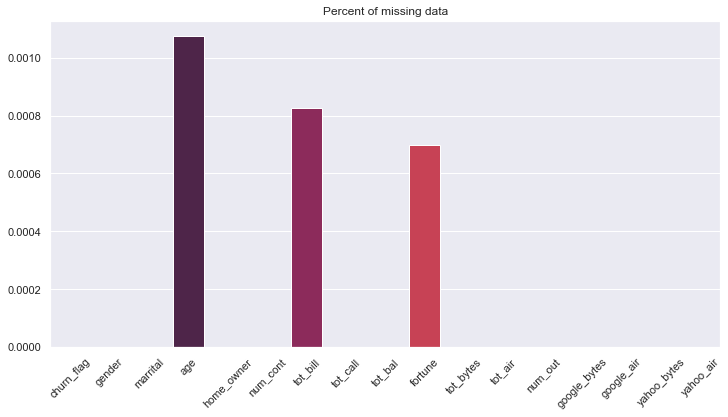

In [4]:
nan_percent = pd.isnull(data).sum(axis=0)/data.shape[0]

plt.figure(figsize=(12,6))
sns.barplot(x=nan_percent.index, y=nan_percent, palette='rocket')
plt.xticks(rotation=45)
plt.title('Percent of missing data')

nan_percent.to_frame().rename(columns={0: 'Missing value percent'}).style.format("{:.2%}")

In [5]:
categorical_feature_mask = data.dtypes==object
categorical_features = data.columns[categorical_feature_mask].tolist()
for col in data.columns:
    if data[col].value_counts().shape[0] == 2 and col not in categorical_features:
        categorical_features.append(col)
categorical_features.remove(y_label)

numeric_feature_mask = data.dtypes!=object
numeric_features = data.columns[numeric_feature_mask].tolist()
numeric_features.remove(y_label)
for feature in numeric_features:
    if feature in categorical_features:
        numeric_features.remove(feature)

print('Categorical features:', categorical_features)
print('Numeric features:', numeric_features)
print('y_label:', y_label)

Categorical features: ['gender', 'marrital', 'fortune', 'home_owner']
Numeric features: ['age', 'num_cont', 'tot_bill', 'tot_call', 'tot_bal', 'tot_bytes', 'tot_air', 'num_out', 'google_bytes', 'google_air', 'yahoo_bytes', 'yahoo_air']
y_label: churn_flag


# Plot histograms of “age” group by “churn”

Text(0.5, 0.98, 'histograms of “age” group by “churn”')

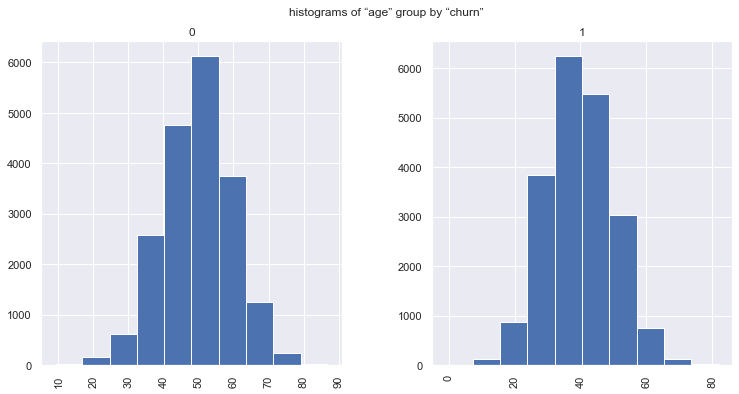

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
data['age'].hist(by=data['churn_flag'], ax=ax)
fig.suptitle('histograms of “age” group by “churn”')

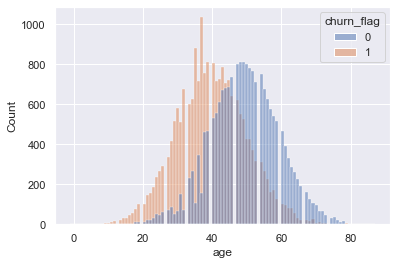

In [7]:
sns.histplot(data=data, x='age', hue='churn_flag', multiple='layer')

# Conduct a t-test of “tot_bill” regarding “churn”

In [8]:
summary, results = rp.ttest(group1=data['tot_bill'][data['churn_flag'] == 1], group1_name='churn',
        group2=data['tot_bill'][data['churn_flag'] == 0], group2_name='not_churn')

In [9]:
summary

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,churn,20501.0,146.510381,24.584078,0.171698,146.173838,146.846924
1,not_churn,19466.0,102.313966,31.260903,0.224059,101.874791,102.753142
2,combined,39967.0,124.984437,35.692830,0.178538,124.634499,125.334375


In [10]:
results

,Independent t-test,results
0,Difference (churn - not_churn) =,44.1964
1,Degrees of freedom =,39965.0000
2,t =,157.5273
3,Two side test p value =,0.0000
4,Difference < 0 p value =,1.0000
5,Difference > 0 p value =,0.0000
6,Cohen's d =,1.5765
7,Hedge's g =,1.5764
8,Glass's delta =,1.7978
9,Pearson's r =,0.6189


In [11]:
from scipy import stats

churn0 = data.where(data.churn_flag== 0).dropna()['tot_bill']
churn1 = data.where(data.churn_flag== 1).dropna()['tot_bill']
print(stats.ttest_ind(churn1,churn0))
print('The test is statistically significant. There is a diffenece between the mean of two groups.')

Ttest_indResult(statistic=157.3899635180336, pvalue=0.0)
The test is statistically significant. There is a diffenece between the mean of two groups.


# Fill out missing values if any, data preprocessing

In [12]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Split the dataset into training and validation sets

In [13]:
X = data.copy().drop(columns=[y_label])
y = data[y_label]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Build a logistic regression model to predict “churn”

In [14]:
model_pipeline = Pipeline([
     ('preprocessor', preprocessor),
     ('clf', LogisticRegression(random_state=0))
])


In [15]:
model_pipeline.fit(X_train, y_train)
pred = model_pipeline.predict(X_train)
score = accuracy_score(y_train, pred)
print("The accuracy score of the model on training set is ", f'{score:.4f}')

The accuracy score of the model on training set is  0.9318


In [16]:
test_pred = model_pipeline.predict(X_test)
test_score = accuracy_score(y_test, test_pred)
print("The accuracy score of the model on test set is ", test_score)

The accuracy score of the model on test set is  0.9309


# Conduct a K-fold cross validation

In [23]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
scores = cross_validate(model_pipeline, X, y, cv=5, scoring=(*metrics,))

for metric in metrics: 
    print(f'{metric:10}:', f'{scores[f"test_{metric}"].mean():.3f}')


accuracy  : 0.930
precision : 0.950
recall    : 0.923
f1        : 0.926
roc_auc   : 0.939


# Interpret the result

The model achieved 93% accuracy on both the training set and the test set. The model is not overfitting because the score of the training and test sets are close and the average accuracy score from cross validation is also high at 93
%. The precision is at around 95% and the recall is at 92%. The F1 is at 92.6% and roc_auc is at 94%, suggesting that the logistic regression model actually fits the data quite well. However, ideally, we want to identify anyone who might choose to churn in the future and therefore we would prefer a higher recall than precision in this case. 

# Test model performance

In [18]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'num_cont',
                                                   'tot_bill', 'tot_call',
                                                   'tot_bal', 'tot_bytes',
                                                   'tot_air', 'num_out',
                                                   'google_bytes', 'google_air',
                                                   'yahoo_bytes',
                                                   'yahoo_air']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strate

Text(0.5, 1.0, 'ROC curve')

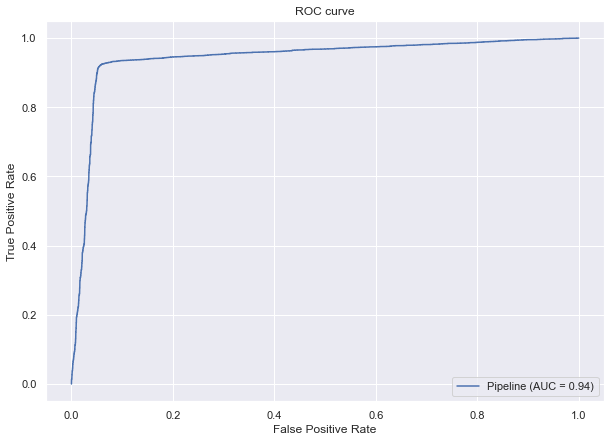

In [19]:
fig, ax = plt.subplots(figsize=(10, 7))
plot_roc_curve(model_pipeline, X_test, y_test, ax=ax)
plt.title('ROC curve')

Text(0.5, 1.0, 'Precision-recall curve')

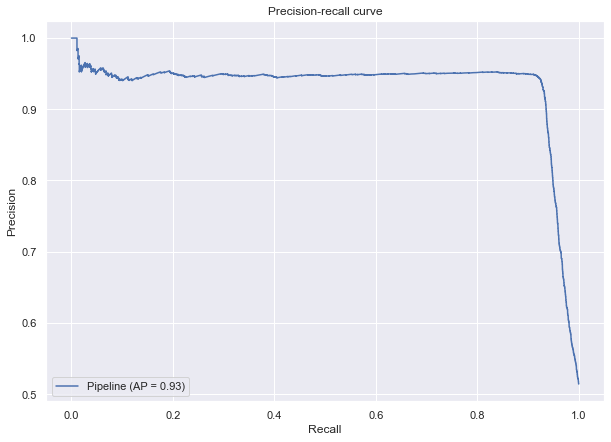

In [20]:
fig, ax = plt.subplots(figsize=(10, 7))
plot_precision_recall_curve(model_pipeline, X_test, y_test, ax=ax)
plt.title('Precision-recall curve')

# Data transformation can improve the performance

In [21]:
def run_model(model_pipleline):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    scores = cross_validate(model_pipeline, X, y, cv=5, scoring=(*metrics,))

    for metric in metrics: 
        print(f'{metric:10}:', f'{scores[f"test_{metric}"].mean():.3f}')
    
    model_pipeline.fit(X_train, y_train)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    plot_roc_curve(model_pipeline, X_test, y_test, ax=ax)
    plt.title('ROC curve')
    
    fig, ax = plt.subplots(figsize=(10, 7))
    plot_precision_recall_curve(model_pipeline, X_test, y_test, ax=ax)
    plt.title('Precision-recall curve')    

accuracy  : 0.930
precision : 0.950
recall    : 0.923
f1        : 0.926
roc_auc   : 0.939


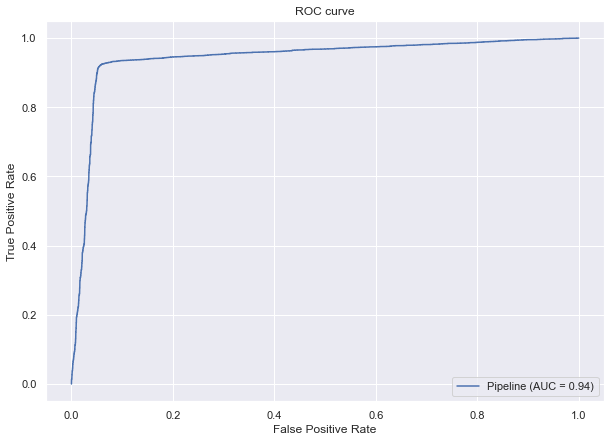

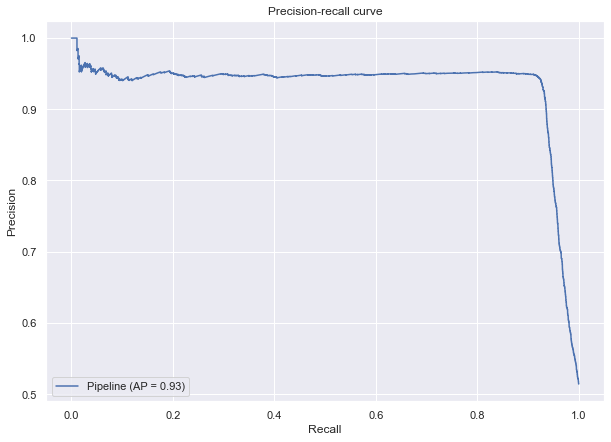

In [22]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler()),
    ('polyfeature', PolynomialFeatures(degree=2, interaction_only=True)),    
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value="Unkown")),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

model_pipeline_new = Pipeline([
     ('preprocessor', preprocessor),
     ('clf', LogisticRegression(random_state=0))
])

run_model(model_pipeline_new)

As shown above, by changing the method of filling null values in categorical features from using the most frequent value to using a constant value "Unknown", the model's performance hardly improved, this may due to the already high score of the model, leaving limited space for improving.

# Summarize findings

1. The data given has 40000 entries and 17 columns. There are 43 missing values in 'age', 33 missing values in 'tot_bill' and 28 missing values in 'fortune'.

2. Numerical features including: ['age', 'num_cont', 'tot_bill', 'tot_call', 'tot_bal', 'tot_bytes', 'tot_air', 'num_out', 'google_bytes', 'google_air', 'yahoo_bytes', 'yahoo_air'];    Categorical features including ['gender', 'marrital', 'fortune', 'home_owner']. 

3. According to the histograms of "age" group by "churn", we found that people who churned appeared to be in a younger age group than those who did not churn.

4. The t-test of "tot_bill" regarding "churn" suggests that there is significant difference in the mean of tot_bill between churn and not churn groups. The mean of total bill of people who churned is much higher than that of those who did not churn. 

5. The logistic regression model fits the data quite well and achieved high scores in accuracy, precision, recall, f1 and roc_auc. Data transformations like including polynomial numerical features and changing imputation method of fillna of categorical features may be able to slightly improve the performance of the model.

